<a href="https://colab.research.google.com/github/Ikeda33/codespaces-railstutorial/blob/main/cnn2_50epoch_flower_D_c_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=128)
parser.add_argument("--nch_d", type = int, default=128)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=50, batch_size=32, lr_g=0.0002, lr_d=0.0003, nch_g=128, nch_d=128, z_dim=100, beta1=0.5)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform


    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img

    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([

    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),

        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),

    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()

    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2


    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)

        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)

        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z)
        z = self.relu(z)

        z = self.conv2(z)
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2\n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels)\n        self.bn = n

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding\n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)


    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x

    def forward(self, x):

        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity


        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x)


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)

        return x

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)

    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x

    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()

        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels

        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )


    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE_G(out_channels))
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))



        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.convt1(x)

        out = self.convt2(out)

        out = self.convt3(out)

        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)


    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))


        net = nn.Sequential(*layers)#listのアンパック

        return net

    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)

        out = self.conv3(out)

        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 0, lossD:3.290563265603144, lossG:22.01114547136918,lossG_fake:15.610557063111981, lossG_real:6.400588249480261 ,equality:9.20996881363172


evaluate:83.65377807617188,kid_mean:0.03313491865992546, kid_std:0.011007769033312798,kid_:(tensor(0.0331), tensor(0.0110))


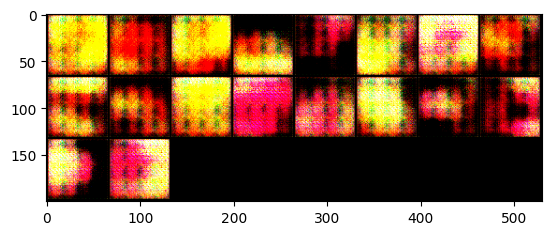

100%|██████████| 103/103 [00:21<00:00,  4.70it/s]


epoch: 1, lossD:1.8104180195956554, lossG:7.665040289314048,lossG_fake:4.517458642570718, lossG_real:3.1475816131795495 ,equality:1.3698770293911684


evaluate:93.5797119140625,kid_mean:0.04498285427689552, kid_std:0.023898005485534668,kid_:(tensor(0.0450), tensor(0.0239))


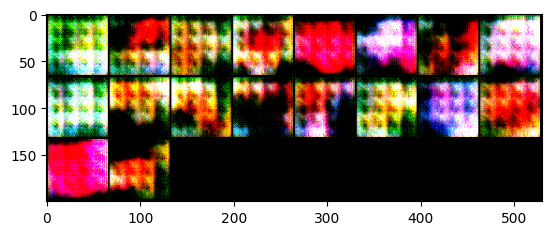

100%|██████████| 103/103 [00:20<00:00,  4.92it/s]


epoch: 2, lossD:1.5477572204997239, lossG:6.833683643526244,lossG_fake:3.9535014805863207, lossG_real:2.8801821600464943 ,equality:1.0733193205398264


evaluate:94.35588836669922,kid_mean:0.052406519651412964, kid_std:0.027013123035430908,kid_:(tensor(0.0524), tensor(0.0270))


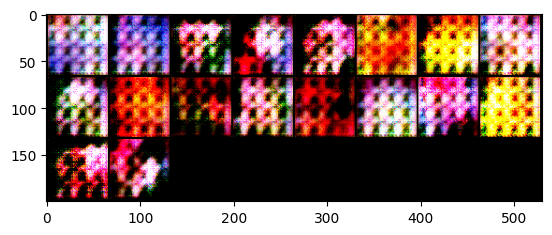

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 3, lossD:1.7731249662278925, lossG:5.720405266122911,lossG_fake:3.3336974463416533, lossG_real:2.386707810522283 ,equality:0.9469896358193703


evaluate:87.05738830566406,kid_mean:0.04673140496015549, kid_std:0.023008348420262337,kid_:(tensor(0.0467), tensor(0.0230))


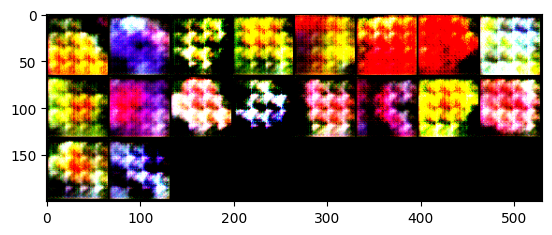

100%|██████████| 103/103 [00:21<00:00,  4.80it/s]


epoch: 4, lossD:1.639608130871671, lossG:5.92155930139486,lossG_fake:3.4971526039456857, lossG_real:2.4244066889135585 ,equality:1.0727459150321272


evaluate:99.6911849975586,kid_mean:0.061666879802942276, kid_std:0.03225146606564522,kid_:(tensor(0.0617), tensor(0.0323))


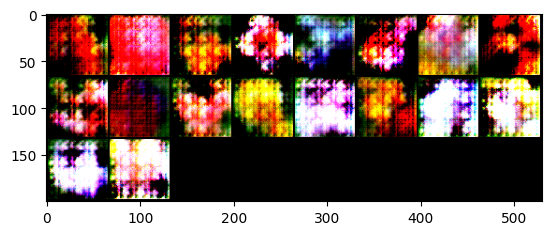

100%|██████████| 103/103 [00:21<00:00,  4.89it/s]


epoch: 5, lossD:1.4572852468027653, lossG:6.010497019128892,lossG_fake:3.551901220117958, lossG_real:2.4585957914880177 ,equality:1.0933054286299404


evaluate:100.14527130126953,kid_mean:0.06277794390916824, kid_std:0.03095925599336624,kid_:(tensor(0.0628), tensor(0.0310))


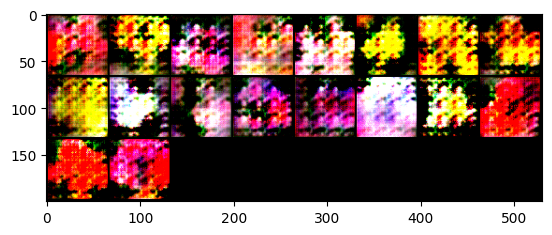

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 6, lossD:1.5533045515852066, lossG:5.817785119547428,lossG_fake:3.418736782467481, lossG_real:2.399048369486355 ,equality:1.0196884129811261


evaluate:96.49855041503906,kid_mean:0.06180642545223236, kid_std:0.03330102935433388,kid_:(tensor(0.0618), tensor(0.0333))


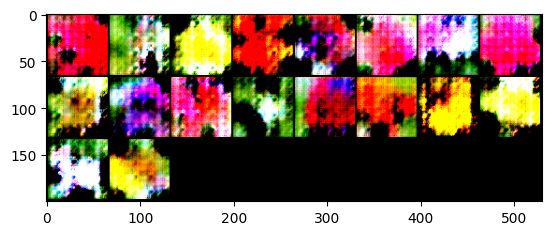

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 7, lossD:1.4844011386621345, lossG:5.977949855397049,lossG_fake:3.5189038995400215, lossG_real:2.4590459616438856 ,equality:1.059857937896136


evaluate:90.25322723388672,kid_mean:0.058364301919937134, kid_std:0.029001783579587936,kid_:(tensor(0.0584), tensor(0.0290))


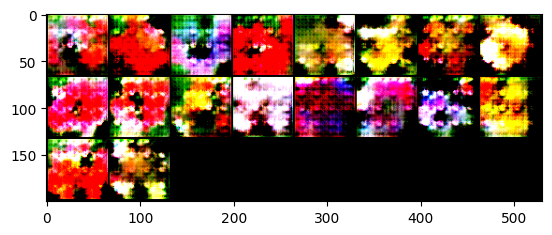

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 8, lossD:1.3576701827419615, lossG:6.15394991809882,lossG_fake:3.647756724681669, lossG_real:2.506193198046638 ,equality:1.1415635266350312


evaluate:89.54793548583984,kid_mean:0.05070865526795387, kid_std:0.03172788396477699,kid_:(tensor(0.0507), tensor(0.0317))


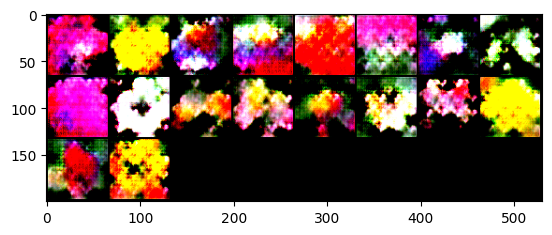

100%|██████████| 103/103 [00:21<00:00,  4.84it/s]


epoch: 9, lossD:1.4140445833067292, lossG:5.917070041582423,lossG_fake:3.549978787459216, lossG_real:2.3670912593313793 ,equality:1.1828875281278366


evaluate:90.21587371826172,kid_mean:0.055222492665052414, kid_std:0.03281687945127487,kid_:(tensor(0.0552), tensor(0.0328))


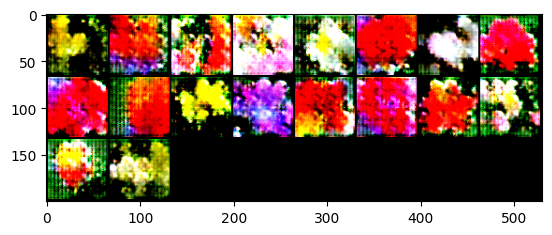

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 10, lossD:1.480143878066424, lossG:5.714851837713741,lossG_fake:3.330676880855005, lossG_real:2.38417494731042 ,equality:0.9465019335445848


evaluate:95.84002685546875,kid_mean:0.06274767220020294, kid_std:0.03353290259838104,kid_:(tensor(0.0627), tensor(0.0335))


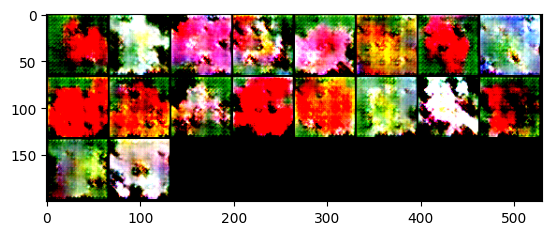

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 11, lossD:1.4497768497004093, lossG:5.739885894997606,lossG_fake:3.392508115583253, lossG_real:2.347377788673327 ,equality:1.0451303269099261


evaluate:98.87179565429688,kid_mean:0.056155938655138016, kid_std:0.032936301082372665,kid_:(tensor(0.0562), tensor(0.0329))


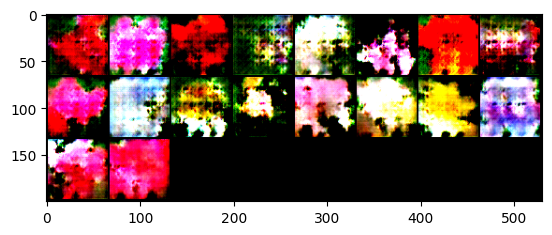

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 12, lossD:1.3848188299577213, lossG:5.728483204702729,lossG_fake:3.331064995052745, lossG_real:2.3974182049481616 ,equality:0.9336467901045835


evaluate:98.58126068115234,kid_mean:0.06815041601657867, kid_std:0.03675062581896782,kid_:(tensor(0.0682), tensor(0.0368))


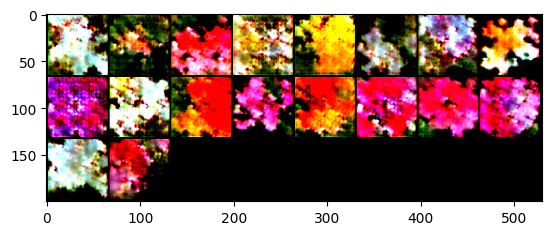

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 13, lossD:1.3558019173955453, lossG:5.938622488558871,lossG_fake:3.4748883189506903, lossG_real:2.463734164400008 ,equality:1.0111541545506824


evaluate:99.56359100341797,kid_mean:0.07049767673015594, kid_std:0.03783023729920387,kid_:(tensor(0.0705), tensor(0.0378))


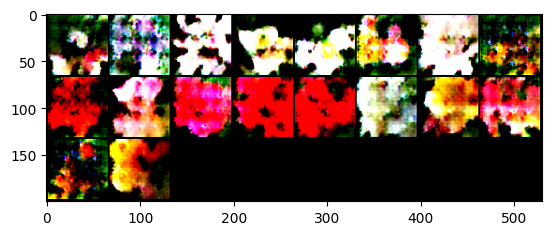

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 14, lossD:1.3221197200631631, lossG:6.018444700148499,lossG_fake:3.4860942109117232, lossG_real:2.5323504750589723 ,equality:0.953743735852751


evaluate:94.70555114746094,kid_mean:0.0693754181265831, kid_std:0.035723838955163956,kid_:(tensor(0.0694), tensor(0.0357))


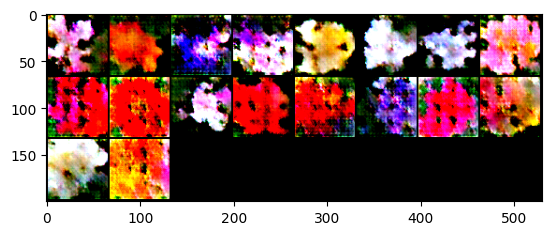

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 15, lossD:1.2253404789179274, lossG:6.276147911849531,lossG_fake:3.667849855515563, lossG_real:2.608298036658648 ,equality:1.059551818856915


evaluate:90.67454528808594,kid_mean:0.06570401042699814, kid_std:0.0459565594792366,kid_:(tensor(0.0657), tensor(0.0460))


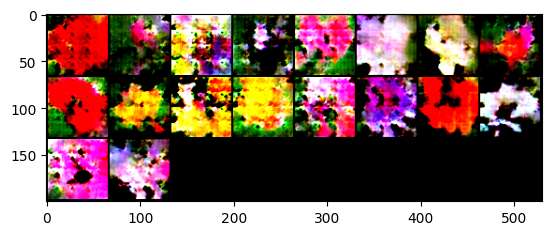

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 16, lossD:1.1552221885005247, lossG:6.329353295483635,lossG_fake:3.619851386662826, lossG_real:2.7095019195264984 ,equality:0.9103494671363275


evaluate:86.65483856201172,kid_mean:0.06334639340639114, kid_std:0.03535040095448494,kid_:(tensor(0.0633), tensor(0.0354))


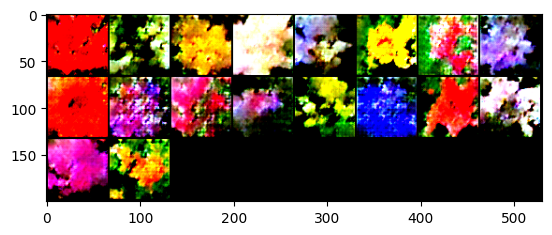

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 17, lossD:1.161135936246335, lossG:6.429713346425769,lossG_fake:3.588986873626709, lossG_real:2.840726495946495 ,equality:0.7482603776802139


evaluate:88.12522888183594,kid_mean:0.06348885595798492, kid_std:0.03806338086724281,kid_:(tensor(0.0635), tensor(0.0381))


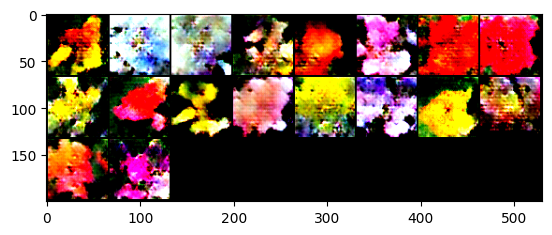

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 18, lossD:1.182830635205056, lossG:6.572918359515737,lossG_fake:3.725382955328932, lossG_real:2.847535413445778 ,equality:0.877847541883154


evaluate:87.63117980957031,kid_mean:0.06364698708057404, kid_std:0.03828790411353111,kid_:(tensor(0.0636), tensor(0.0383))


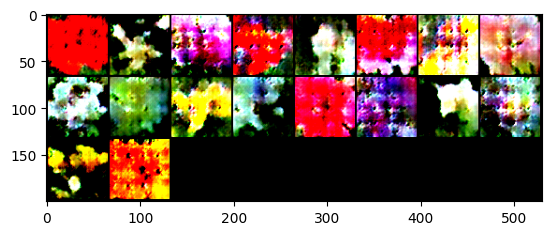

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 19, lossD:1.0879387137959304, lossG:6.552867981994036,lossG_fake:3.7461294398724454, lossG_real:2.806738541542905 ,equality:0.9393908983295405


evaluate:87.14043426513672,kid_mean:0.06441619247198105, kid_std:0.03889190033078194,kid_:(tensor(0.0644), tensor(0.0389))


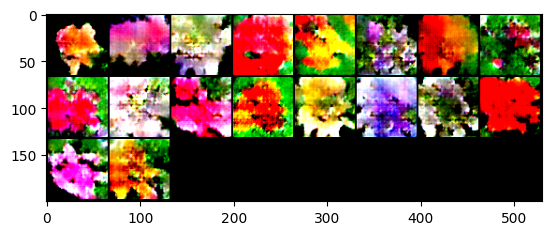

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 20, lossD:1.0764756630925298, lossG:6.711168141040988,lossG_fake:3.76743178807416, lossG_real:2.943736354413542 ,equality:0.8236954336606179


evaluate:84.97806549072266,kid_mean:0.06326042860746384, kid_std:0.03061615116894245,kid_:(tensor(0.0633), tensor(0.0306))


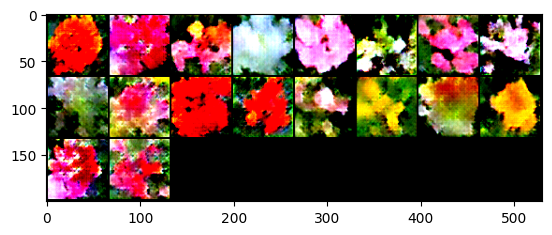

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 21, lossD:1.1042768544363744, lossG:6.636670709813683,lossG_fake:3.7294096379604156, lossG_real:2.907261087188443 ,equality:0.8221485507719728


evaluate:82.91390991210938,kid_mean:0.06095447018742561, kid_std:0.0354132354259491,kid_:(tensor(0.0610), tensor(0.0354))


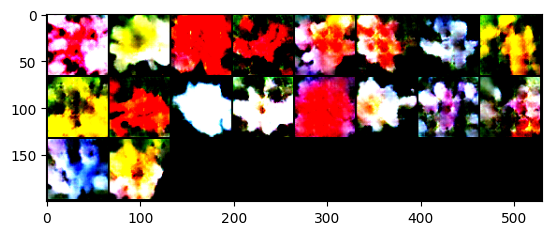

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 22, lossD:1.0999209020033622, lossG:6.756859034010508,lossG_fake:3.8124392391408533, lossG_real:2.9444198070220575 ,equality:0.8680194321187957


evaluate:85.157958984375,kid_mean:0.05625671520829201, kid_std:0.0349135585129261,kid_:(tensor(0.0563), tensor(0.0349))


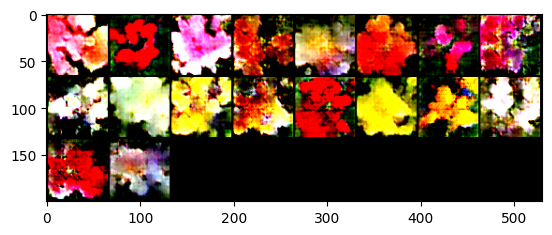

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 23, lossD:1.0629658516749596, lossG:6.584119778234982,lossG_fake:3.662988941646317, lossG_real:2.921130868705731 ,equality:0.7418580729405857


evaluate:86.76099395751953,kid_mean:0.06537559628486633, kid_std:0.04029242321848869,kid_:(tensor(0.0654), tensor(0.0403))


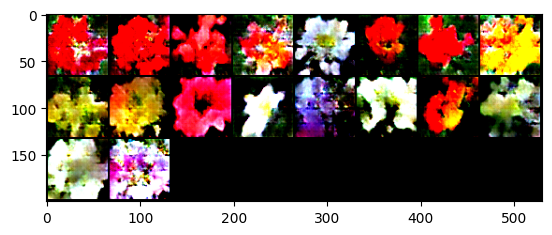

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 24, lossD:1.0878919624877208, lossG:6.701087965548617,lossG_fake:3.7989934439798003, lossG_real:2.9020944917664946 ,equality:0.8968989522133057


evaluate:87.75878143310547,kid_mean:0.06771725416183472, kid_std:0.042503371834754944,kid_:(tensor(0.0677), tensor(0.0425))


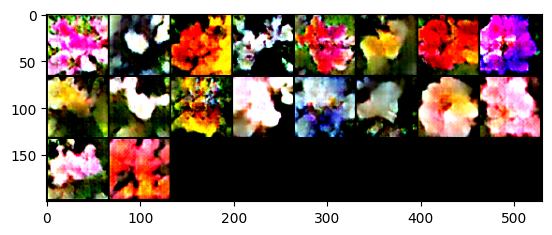

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 25, lossD:1.0480224896692536, lossG:6.8546969173024,lossG_fake:3.824841562984059, lossG_real:3.0298553473741103 ,equality:0.7949862156099488


evaluate:88.0427017211914,kid_mean:0.0631682425737381, kid_std:0.03890063613653183,kid_:(tensor(0.0632), tensor(0.0389))


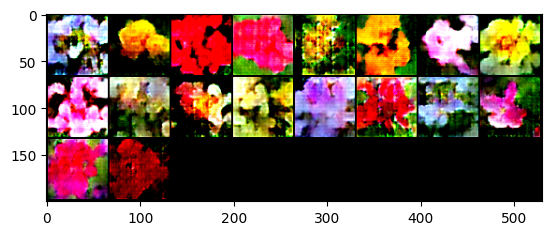

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 26, lossD:0.9870212650993495, lossG:7.079717849064799,lossG_fake:4.010081029632716, lossG_real:3.0696368379500307 ,equality:0.9404441916826856


evaluate:90.48123931884766,kid_mean:0.06491050124168396, kid_std:0.037407584488391876,kid_:(tensor(0.0649), tensor(0.0374))


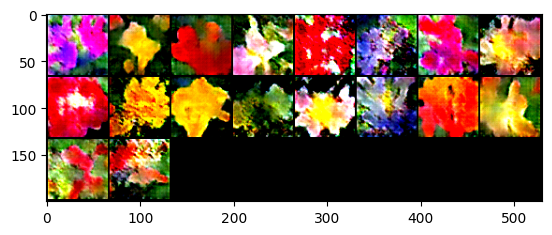

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 27, lossD:1.035500177191299, lossG:6.748971545580521,lossG_fake:3.7353378875741683, lossG_real:3.013633663214526 ,equality:0.7217042243596423


evaluate:89.30390167236328,kid_mean:0.061911970376968384, kid_std:0.03670123964548111,kid_:(tensor(0.0619), tensor(0.0367))


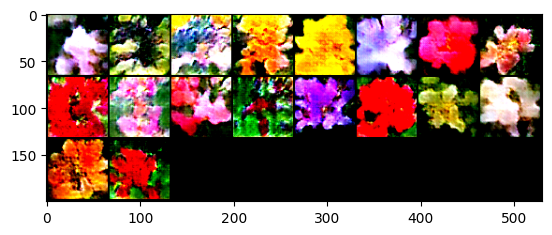

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 28, lossD:1.0592402465713835, lossG:6.901280741089756,lossG_fake:3.8850183486938477, lossG_real:3.016262420751516 ,equality:0.8687559279423316


evaluate:89.3316421508789,kid_mean:0.062473367899656296, kid_std:0.037050433456897736,kid_:(tensor(0.0625), tensor(0.0371))


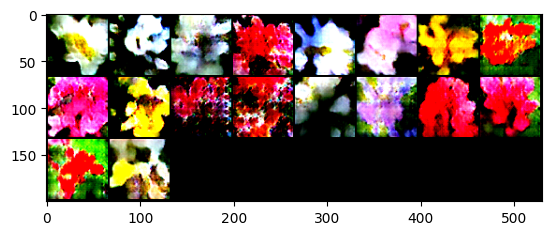

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 29, lossD:1.0004333558591825, lossG:7.063180738282435,lossG_fake:4.00448262807235, lossG_real:3.058698102687169 ,equality:0.9457845253851809


evaluate:90.5087890625,kid_mean:0.06541425734758377, kid_std:0.030545376241207123,kid_:(tensor(0.0654), tensor(0.0305))


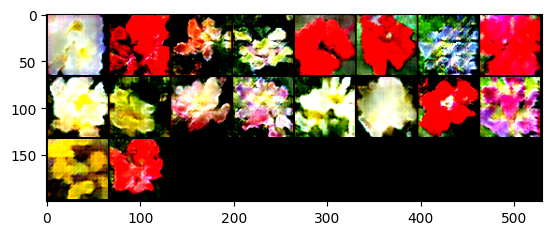

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 30, lossD:0.9854829188400102, lossG:7.141387291324949,lossG_fake:3.988228566438249, lossG_real:3.1531587133129824 ,equality:0.8350698531252667


evaluate:89.51560974121094,kid_mean:0.07006841897964478, kid_std:0.04073638841509819,kid_:(tensor(0.0701), tensor(0.0407))


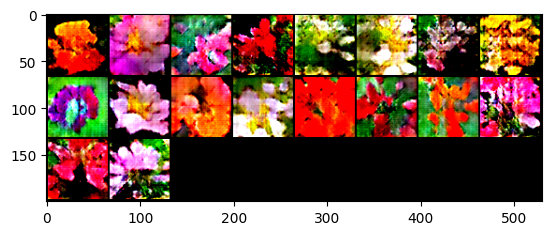

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 31, lossD:1.009931099067614, lossG:7.04834866755217,lossG_fake:3.981074315830342, lossG_real:3.0672743378333673 ,equality:0.9137999779969745


evaluate:91.60106658935547,kid_mean:0.06371866911649704, kid_std:0.03806127980351448,kid_:(tensor(0.0637), tensor(0.0381))


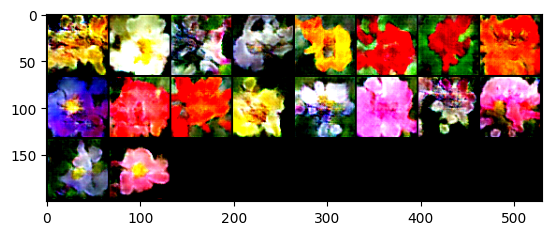

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 32, lossD:0.9148372880463461, lossG:7.098178868154878,lossG_fake:3.9399822290661266, lossG_real:3.1581966333018925 ,equality:0.7817855957642341


evaluate:91.32548522949219,kid_mean:0.05770619213581085, kid_std:0.037179846316576004,kid_:(tensor(0.0577), tensor(0.0372))


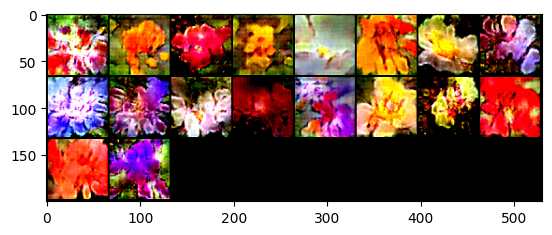

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 33, lossD:0.8247105401117825, lossG:7.457659443605293,lossG_fake:4.175764233163259, lossG_real:3.281895209863348 ,equality:0.8938690232999114


evaluate:90.90148162841797,kid_mean:0.056205540895462036, kid_std:0.03120427019894123,kid_:(tensor(0.0562), tensor(0.0312))


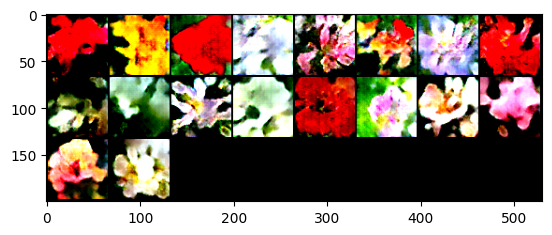

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 34, lossD:0.9701115337824359, lossG:7.378863311508327,lossG_fake:4.116042666064883, lossG_real:3.262820664829421 ,equality:0.8532220012354617


evaluate:91.63040924072266,kid_mean:0.05887363478541374, kid_std:0.03572388365864754,kid_:(tensor(0.0589), tensor(0.0357))


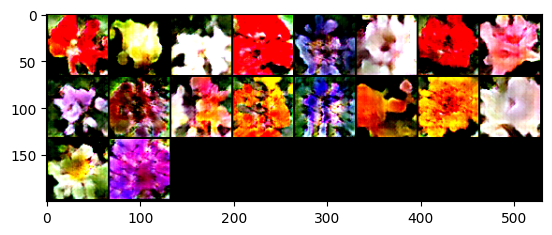

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 35, lossD:0.9396546723194492, lossG:7.276642729935137,lossG_fake:4.076413825877662, lossG_real:3.200228884960841 ,equality:0.8761849409168208


evaluate:90.58914184570312,kid_mean:0.060766275972127914, kid_std:0.03571007028222084,kid_:(tensor(0.0608), tensor(0.0357))


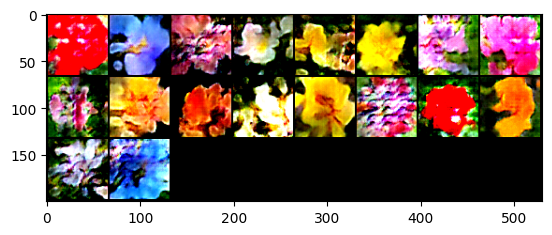

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 36, lossD:0.86514108027648, lossG:7.588550729658997,lossG_fake:4.245781059404021, lossG_real:3.342769656945201 ,equality:0.9030114024588203


evaluate:90.35196685791016,kid_mean:0.06673049926757812, kid_std:0.0415588840842247,kid_:(tensor(0.0667), tensor(0.0416))


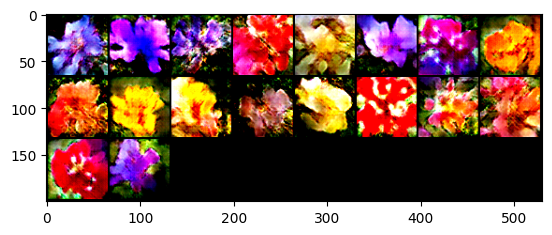

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 37, lossD:0.9176243775099227, lossG:7.274004575118278,lossG_fake:4.0531744980117645, lossG_real:3.2208300863654866 ,equality:0.8323444116462779


evaluate:90.34693908691406,kid_mean:0.06086665019392967, kid_std:0.035405442118644714,kid_:(tensor(0.0609), tensor(0.0354))


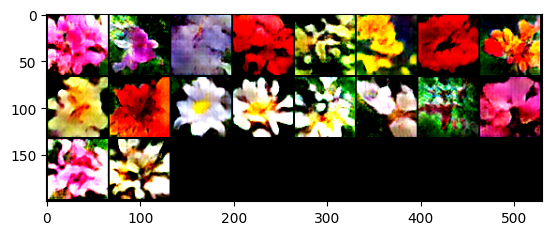

100%|██████████| 103/103 [00:21<00:00,  4.85it/s]


epoch: 38, lossD:0.816814888304877, lossG:7.456833496834468,lossG_fake:4.159418317299445, lossG_real:3.297415161017075 ,equality:0.8620031562823698


evaluate:90.50816345214844,kid_mean:0.06227802112698555, kid_std:0.038849491626024246,kid_:(tensor(0.0623), tensor(0.0388))


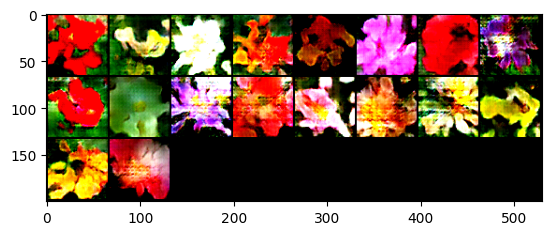

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 39, lossD:0.8668450957652435, lossG:7.621870411252512,lossG_fake:4.245453118699269, lossG_real:3.376417275771354 ,equality:0.8690358429279144


evaluate:91.48533630371094,kid_mean:0.05869206413626671, kid_std:0.03370193392038345,kid_:(tensor(0.0587), tensor(0.0337))


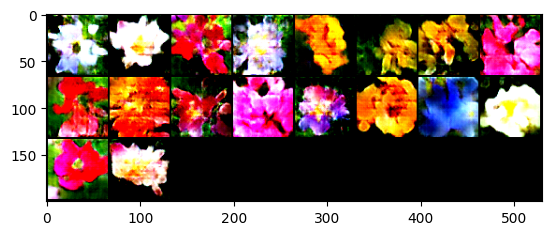

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 40, lossD:0.9527654474221386, lossG:7.349890537632322,lossG_fake:4.016448578209553, lossG_real:3.333441962894884 ,equality:0.6830066153146688


evaluate:92.66665649414062,kid_mean:0.057967644184827805, kid_std:0.029157739132642746,kid_:(tensor(0.0580), tensor(0.0292))


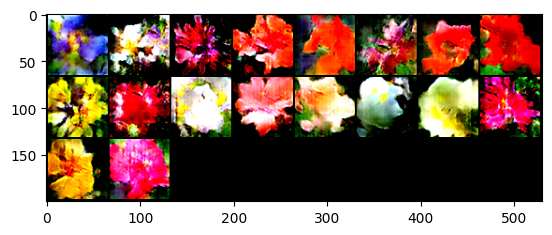

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 41, lossD:0.7604799228675158, lossG:7.5305754837480565,lossG_fake:4.098861795027279, lossG_real:3.431713684669976 ,equality:0.6671481103573029


evaluate:92.61194610595703,kid_mean:0.06433898210525513, kid_std:0.032152678817510605,kid_:(tensor(0.0643), tensor(0.0322))


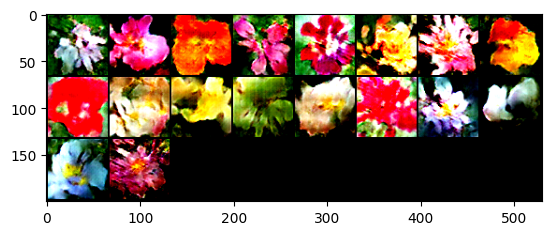

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 42, lossD:0.8771090316540987, lossG:7.838544285413131,lossG_fake:4.457683500734348, lossG_real:3.3808608386412407 ,equality:1.076822662093107


evaluate:94.4335708618164,kid_mean:0.061718735843896866, kid_std:0.03648820519447327,kid_:(tensor(0.0617), tensor(0.0365))


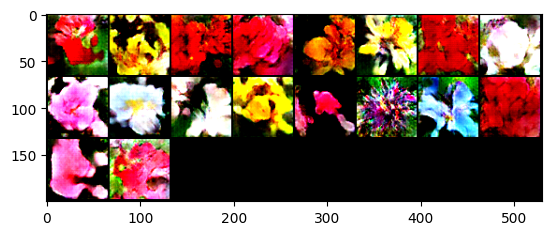

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 43, lossD:0.8831965693281693, lossG:7.636445448236558,lossG_fake:4.186547059457279, lossG_real:3.4498983725760746 ,equality:0.7366486868812046


evaluate:95.33285522460938,kid_mean:0.07033098489046097, kid_std:0.037555381655693054,kid_:(tensor(0.0703), tensor(0.0376))


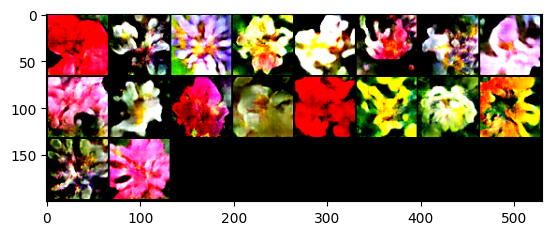

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 44, lossD:0.7845517618274226, lossG:7.57724117538304,lossG_fake:4.139603919195897, lossG_real:3.4376372596592577 ,equality:0.7019666595366396


evaluate:97.28661346435547,kid_mean:0.06331576406955719, kid_std:0.03723587468266487,kid_:(tensor(0.0633), tensor(0.0372))


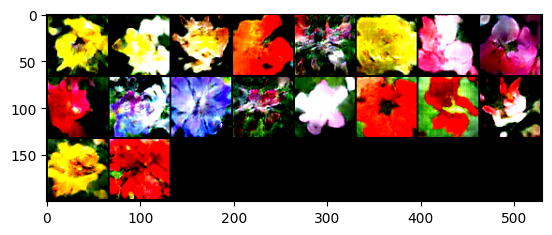

100%|██████████| 103/103 [00:21<00:00,  4.88it/s]


epoch: 45, lossD:0.7745630519772039, lossG:7.812850216060009,lossG_fake:4.312670407943355, lossG_real:3.5001797988576797 ,equality:0.8124906090856756


evaluate:97.26819610595703,kid_mean:0.06615133583545685, kid_std:0.0424250029027462,kid_:(tensor(0.0662), tensor(0.0424))


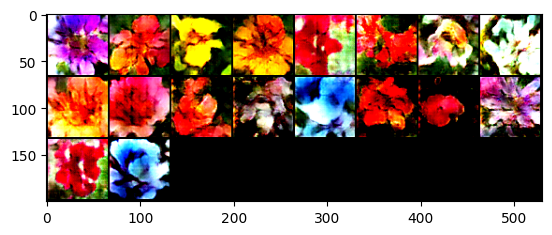

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 46, lossD:0.7647676279099243, lossG:7.864810013076634,lossG_fake:4.318585955980912, lossG_real:3.5462240241106273 ,equality:0.7723619318702846


evaluate:98.28083801269531,kid_mean:0.06948758661746979, kid_std:0.042577482759952545,kid_:(tensor(0.0695), tensor(0.0426))


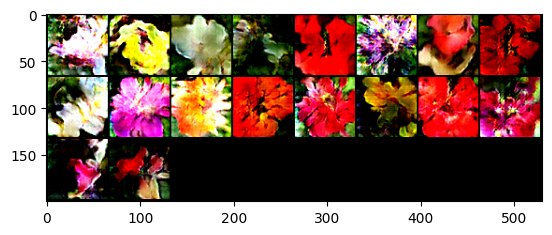

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 47, lossD:0.7820213711232815, lossG:7.911415725078397,lossG_fake:4.332093807100092, lossG_real:3.5793219087193315 ,equality:0.7527718983807605


evaluate:98.58741760253906,kid_mean:0.07200256735086441, kid_std:0.035500239580869675,kid_:(tensor(0.0720), tensor(0.0355))


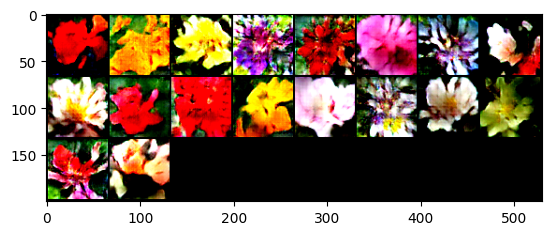

100%|██████████| 103/103 [00:21<00:00,  4.86it/s]


epoch: 48, lossD:0.8087323705837565, lossG:8.004067184855638,lossG_fake:4.393399465431288, lossG_real:3.610667757617617 ,equality:0.7827317078136709


evaluate:98.43836975097656,kid_mean:0.06662534922361374, kid_std:0.03647583723068237,kid_:(tensor(0.0666), tensor(0.0365))


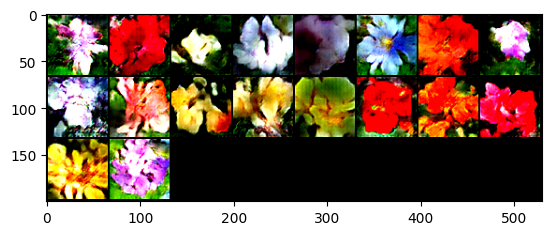

100%|██████████| 103/103 [00:21<00:00,  4.87it/s]


epoch: 49, lossD:0.7179434912876018, lossG:7.88305367312385,lossG_fake:4.28897608252405, lossG_real:3.594077571213824 ,equality:0.6948985113102255


evaluate:98.39523315429688,kid_mean:0.0672285258769989, kid_std:0.042533233761787415,kid_:(tensor(0.0672), tensor(0.0425))


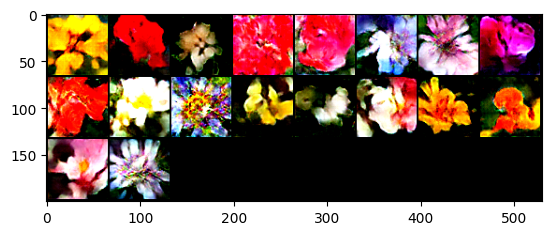

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))


        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()

        #train generator

        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake


        lossG.backward()
        optimizerG.step()

        # save loss

        running_lossD += lossD.item()
        running_lossG += lossG.item()

        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()



    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()



    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

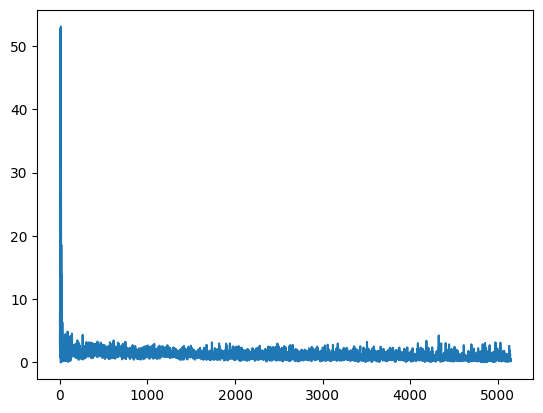

In [45]:
plt.plot(raw_lossesD)

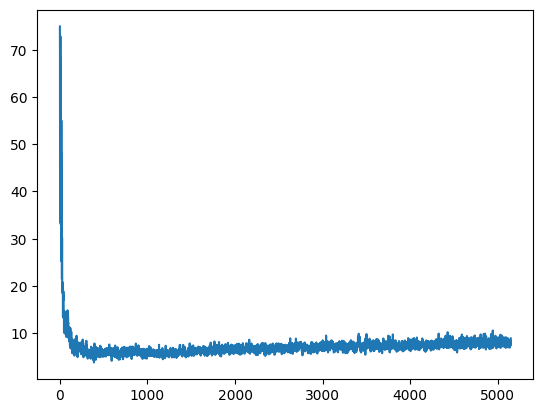

In [46]:
plt.plot(raw_lossesG)

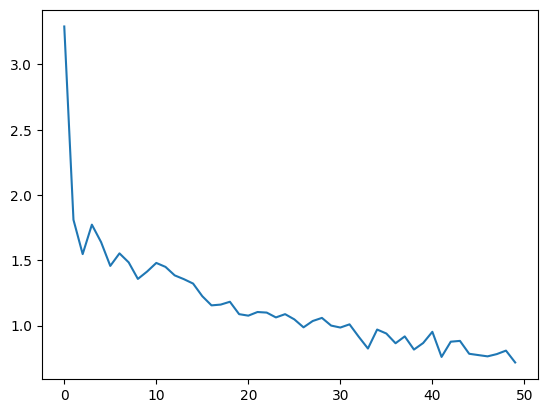

In [47]:
plt.plot(lossesD)

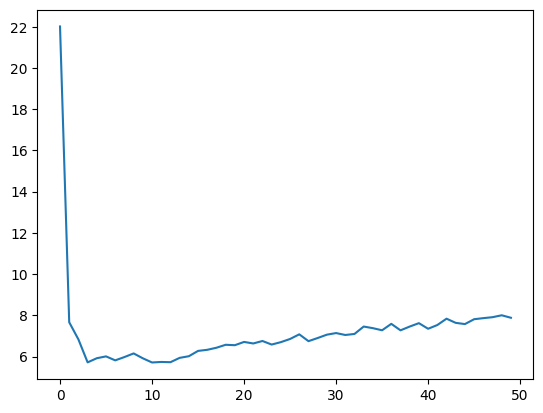

In [48]:
plt.plot(lossesG)

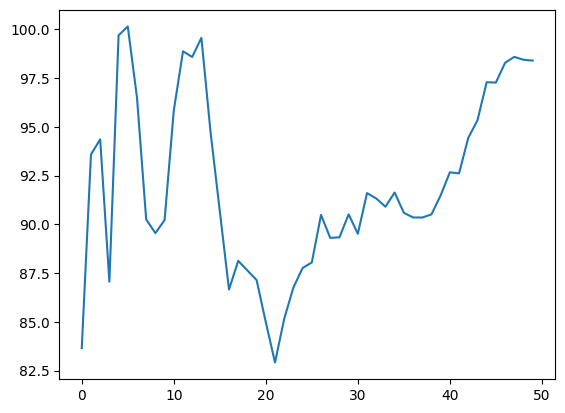

In [49]:
plt.plot(fid_)

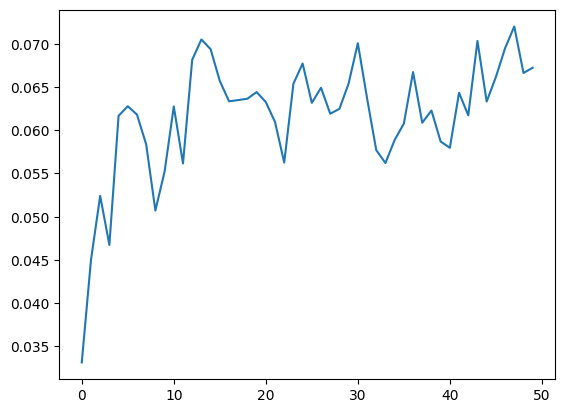

In [50]:
plt.plot(kid_mean_)

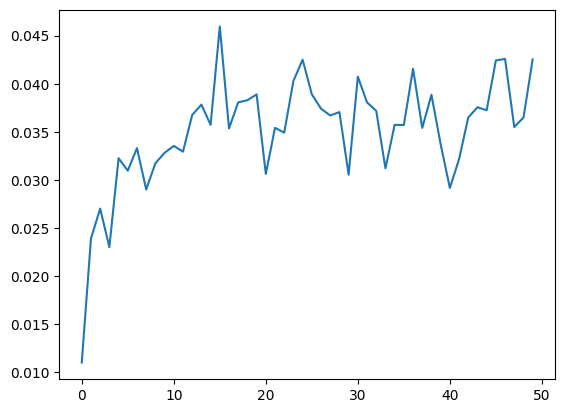

In [51]:
plt.plot(kid_std_)

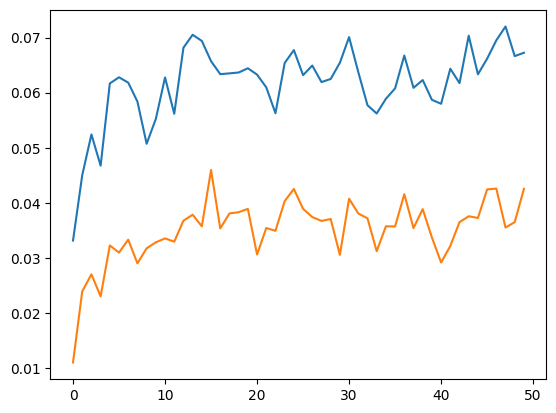

In [52]:
plt.plot(kid_score)

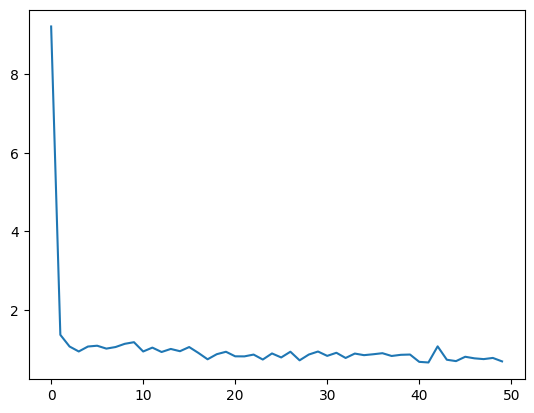

In [53]:
plt.plot(d_equality)

In [54]:

import torch
!pip install torcheval


from torcheval.metrics import PeakSignalNoiseRatio
import torch
import torchvision
#from torcheval.metrics import StructuralSimilarity

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
print(f'fid ',fid.compute())

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
print(f'kid ',kid.compute())

metric = PeakSignalNoiseRatio()
#input = torch.tensor([[0.1, 0.2], [0.3, 0.4]])
#>>> target = input * 0.9
metric.update(fake_imgs,real_imgs)
print(f'PSNR',metric.compute())#高いほどいい
#PSNR (Peak Signal-to-Noise Ratio): PSNRは、生成画像と本物の画像の間のノイズの量を測定します。高いPSNRは、より低いノイズレベルを示します。

import torch
from skimage.metrics import structural_similarity as ssim
import numpy as np

# 例えば、real_imageが与えられているとします
real_image =real_imgs # 仮のランダムな画像データ
fake_image =fake_imgs
# PyTorch TensorをNumPy配列に変換
real_image_np = real_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
real_image_np = np.clip((real_image_np + 1) / 2.0, 0, 1)

# PyTorch TensorをNumPy配列に変換
fake_image_np = fake_image.cpu().numpy()

# SSIMを計算するために、0から1の範囲に正規化することが推奨されます
fake_image_np = np.clip((fake_image_np + 1) / 2.0, 0, 1)

# SSIMを計算
ssim_value = ssim(real_image_np[0], fake_image_np[0], win_size=3)
print(f"SSIM値: {ssim_value}")
#SSIMは、画像の品質を評価するための指標であり、生成画像と本物の画像の構造的な類似性を測定します。1に近い値が高い品質を示します。



fid  tensor(98.3559)
kid  (tensor(0.0651), tensor(0.0433))
PSNR tensor(74.1747)
SSIM値: 0.9590333920885767
